In [1]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

np.random.seed(0)

from openpyxl import load_workbook
from openpyxl.styles import Font, PatternFill
from export_to_xlsx import save_opening_output_file

In [2]:
def set_predicted_in_xls(file_xlsx_path, df):
    print('set_predicted_in_xls')    
    try:
        save_opening_output_file(file_xlsx_path)
    except Exception as _ex:
        print(_ex)
        
    wb = load_workbook(file_xlsx_path)
    ws = wb['Sheet1']
    objs = {}
    objs_by_regions = {}
    for i, row in df.iterrows():
        ws[f'W{int(row[0]) + 2}'].number_format = '_-* # ##0₽_-;-* # ##0₽-'
        ws[f'W{int(row[0]) + 2}'] = row["predicted"]
        
        ws[f'X{int(row[0]) + 2}'].number_format = '_-* # ##0₽_-;-* # ##0₽-'
        ws[f'X{int(row[0]) + 2}'] = row["predicted"]-row["Цена за кв.м"]
        if row["predicted"]-row["Цена за кв.м"] > 1000:
            ws[f'X{int(row[0]) + 2}'].font = Font(bold=True, color='006100')
            ws[f'X{int(row[0]) + 2}'].fill = PatternFill("solid", fgColor="C6EFCE")
        elif row["predicted"]-row["Цена за кв.м"] < 0:
            ws[f'X{int(row[0]) + 2}'].font  = Font(color="9C0006")
            ws[f'X{int(row[0]) + 2}'].fill  = PatternFill("solid", fgColor="FFC7CE")

    wb.save(file_xlsx_path)
    return

In [3]:
#удаляем выбросы
def remove_row_emissions(data, row_name):
    print("remove emissions ", row_name)
    lower_bound = data[row_name].quantile(q=0.025)
    upper_bound = data[row_name].quantile(q=0.975)
    #print(data)
    data[(data[row_name] < lower_bound) | (data[row_name] > upper_bound)] = np.nan
    data.dropna(subset=[row_name], inplace=True)

# разделяем регионы, которые сильно расходятся в ценовой политике
def split_df_into_price_region(df):
    high = [78, 77]
    middle = [50]
    df_high_price = df[df["Регион"].isin(set(high))].copy()

    df_middle_price = df[
        (((df["Жителей в нп"] > 1000000) & (df["Жителей в нп"] < 5000000)) | (df["Регион"].isin(set(middle)))) & ~(
            df["Регион"].isin(set(high)))].copy()
    df_low_price = df[
        (df["Жителей в нп"] <= 1000000) & (df["Жителей в нп"] >= 100) & ~(
            df["Регион"].isin(set(high + middle)))].copy()
    return df_high_price, df_middle_price, df_low_price

In [4]:
def loading_data(paths):
    numeric_features = ["Жителей", "Жителей в нп", "Коммерческих объектов", "Общая площадь",
                        "Отдельный вход", "Культурное наследие", "Ремонт", "Этаж"]
    df = pd.DataFrame()
    if type(paths) == list:
        for path in paths:
            df = pd.concat((df, pd.read_excel(path),), axis=0)
    else:
        df = pd.read_excel(paths)

    df['Тип объекта'] = df['Тип объекта'].astype("string")

    for name in numeric_features:
        df[name].replace('None', 0, inplace=True)
        df[name].replace(np.nan, 0, inplace=True)

    df['Жителей в нп'] = df['Жителей в нп'].astype(int)
    df.dropna(subset=['Жителей','Жителей в нп'], inplace=True)

    return df

In [5]:
target = "Цена за кв.м"
numeric_features = ["Жителей", "Жителей в нп", "Коммерческих объектов", "Общая площадь", "Отдельный вход", "Культурное наследие", "Ремонт"]
categorical_features = ["Регион", "Форма проведения", "Имущество", "Этаж", "Тип объекта"]
columns = [target] + numeric_features + categorical_features

out_file =  "../torgi/output.xlsx"
training_data = ['../torgi/output_archive.xlsx', '../torgi/output_train.xlsx']
full_df = loading_data(training_data) #, 'torgi/output_train.xlsx']
print(pd.isnull(full_df).any())

Unnamed: 0                        False
Регион                            False
Общая площадь                     False
id                                 True
Название                          False
Окончания подачи заявок           False
Адрес                             False
Цена                              False
Цена за кв.м                      False
Тип объекта                       False
Чел/кв.м                           True
Ком/кв.м                           True
Жителей                           False
Жителей в нп                      False
Коммерческих объектов             False
Расстояние до почты                True
Форма проведения                  False
Имущество                         False
Координаты                         True
Описание коммерческих объектов     True
Кадастровый номер                  True
Этаж                              False
Предсказываемая                    True
Разница с реальной                 True
Отдельный вход                    False


In [6]:
full_df[columns].info

<bound method DataFrame.info of      Цена за кв.м  Жителей  Жителей в нп  Коммерческих объектов  \
0    26729.678639   3142.0        141970                  118.0   
1     2712.887439    725.0           345                    0.0   
2     3182.651191    336.0        260765                    3.0   
3     6632.667374   1745.0         35222                   10.0   
4     7524.245690    846.0         23662                    1.0   
..            ...      ...           ...                    ...   
673   2969.497608    532.0         61677                    0.0   
674   3210.221395    532.0         61677                    0.0   
675   6013.986014    532.0         61677                    0.0   
676  10186.219739   6732.0        373940                   13.0   
677  59818.181818   1062.0         26211                   13.0   

     Общая площадь  Отдельный вход  Культурное наследие  Ремонт  Регион  \
0             52.9               0                  0.0     0.0       1   
1            

<AxesSubplot:title={'center':'Цена за кв.м'}, xlabel='Регион'>

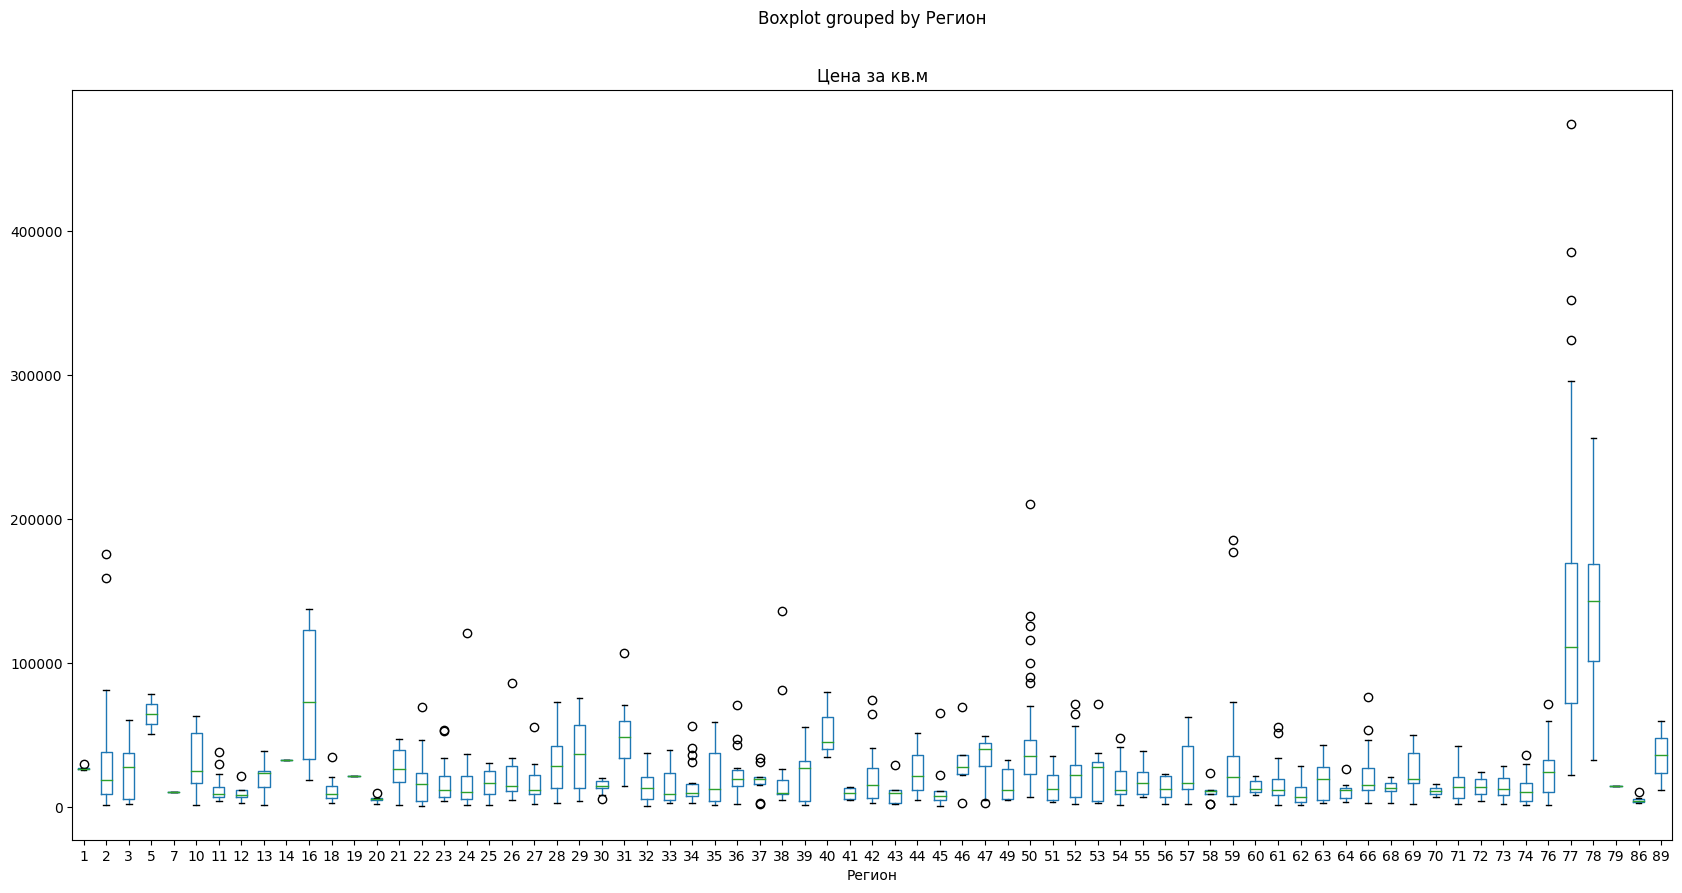

In [7]:
#смотрим в каких регионах сильный разброс цены за кв.м
full_df.boxplot(by ='Регион', column =[target], grid = False, figsize=(20,10))

remove emissions  Цена за кв.м


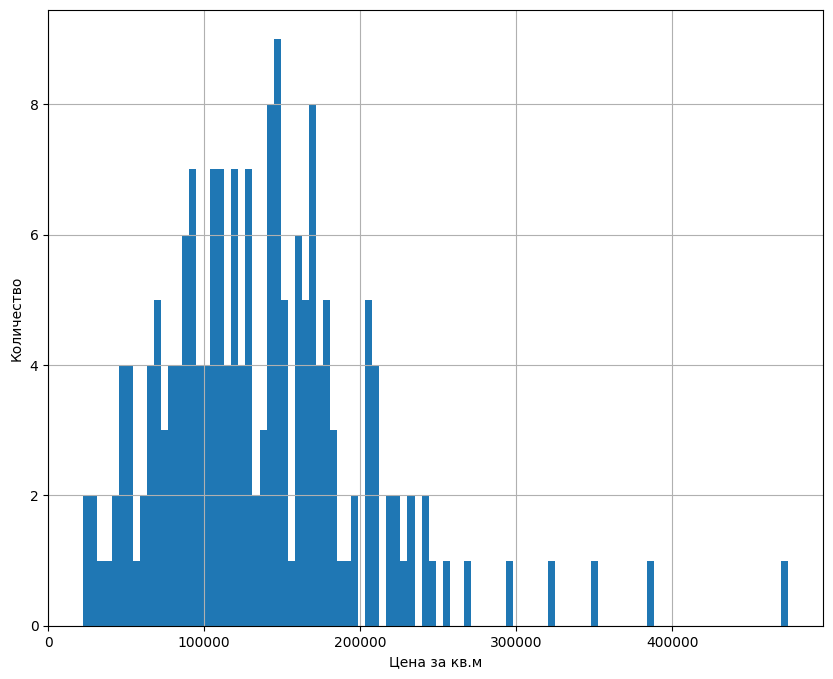

In [8]:
df_high, df_middle, df_low = split_df_into_price_region(full_df)

df_high[target].hist(bins=100, figsize=(10,8)).set(xlabel='Цена за кв.м', ylabel='Количество')
remove_row_emissions(df_high, "Цена за кв.м")


In [9]:
df_high.corrwith(df_high[target])

Unnamed: 0               0.119883
Регион                   0.159970
Общая площадь           -0.561298
Цена                     0.031783
Цена за кв.м             1.000000
Чел/кв.м                 0.602515
Ком/кв.м                 0.113451
Жителей                 -0.032919
Жителей в нп            -0.173798
Коммерческих объектов    0.297803
Расстояние до почты     -0.110491
Этаж                     0.361991
Предсказываемая          0.654803
Разница с реальной      -0.811899
Отдельный вход                NaN
Культурное наследие           NaN
Ремонт                        NaN
Прирост ст              -0.457202
dtype: float64

remove emissions  Цена за кв.м
remove emissions  Цена за кв.м


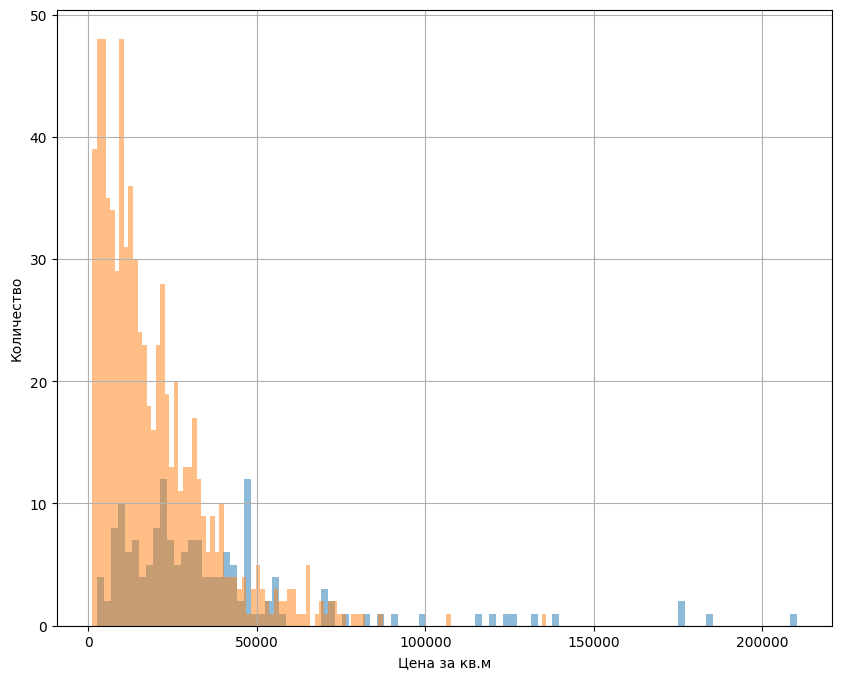

In [10]:
df_middle[target].hist(bins=100, figsize=(10,8), alpha = 0.5).set(xlabel='Цена за кв.м', ylabel='Количество', label='>1mln')
df_low[target].hist(bins=100, figsize=(10,8), alpha = 0.5)

#удаляем выбросы
remove_row_emissions(df_middle, "Цена за кв.м")
remove_row_emissions(df_low, "Цена за кв.м")

In [11]:
df_test_h, df_test_m, df_test_l = split_df_into_price_region(loading_data(out_file))

In [12]:
#подготавливаем модель для обучения
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='median')), ("scaler", MinMaxScaler())]
)
#SimpleImputer(strategy='constant', fill_value=1)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")


#Ridge(alpha=10)
    #model train score: 0.367
    #model test score: 0.300
    #MAE: 10674.231

#KNeighborsRegressor(8)
    #model train score: 0.405
    #model test score: 0.305
    #MAE: 10418.642
#DecisionTreeRegressor(max_depth=4)
    #model train score: 0.435
    #model test score: 0.121
    #MAE: 11433.182

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
clf_h = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", Ridge(alpha=10))]
)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
if not df_test_h.empty:
    #тренируем модель
    
    y_h = df_high["Цена за кв.м"].values
    X_h = df_high[numeric_features + categorical_features]
    #print(X_h)
    clf_h.fit(X_h, y_h)

    
    y_test_h = df_test_h["Цена за кв.м"].values
    X_test_h = df_test_h[numeric_features + categorical_features]

    #Для модели не достаточно данных для обучения, что бы научится адекватно предсказывать цену в этих регионах
    print("model train score: %.3f" % clf_h.score(X_h, y_h))
    print("model test score: %.3f" % clf_h.score(X_test_h, y_test_h))
    print("MAE: %.3f" % mean_absolute_error(y_test_h, clf_h.predict(X_test_h)))
    print("MAE: %.3f" % mean_absolute_error(y_h, clf_h.predict(X_h)))

    # смотрим результаты для Москвы и Питера
    df_test_h['predicted'] = clf_h.predict(df_test_h[numeric_features + categorical_features])
    print(df_test_h[["Цена за кв.м", 'predicted']].head())
    # очень большой разброс, которым нельзя доверять
    #set_predicted_in_xls(out_file, df_test_h)


In [14]:
 if not df_test_m.empty:
        
        clf_m = Pipeline(
            steps=[("preprocessor", preprocessor), ("regressor", DecisionTreeRegressor(max_depth=4))]
        )

        y_m = df_middle["Цена за кв.м"].values
        X_m = df_middle[numeric_features + categorical_features]
        clf_m.fit(X_m, y_m)
        

        y_test_m = df_test_m["Цена за кв.м"].values
        X_test_m = df_test_m[numeric_features + categorical_features]

        print("model train score: %.3f" % clf_m.score(X_m, y_m))
        print("model test score: %.3f" % clf_m.score(X_test_m, y_test_m))
        print("MAE: %.3f" % mean_absolute_error(y_test_m, clf_m.predict(X_test_m)))
        #очень сильные результаты можно на них упираться при принятии решения

        # смотрим результаты для МО ЛО Татарстан, Башкирия, Екат [2, 16, 50, 59, 47]
        df_test_m['predicted'] = clf_m.predict(df_test_m[numeric_features + categorical_features])
        print(df_test_m[["Цена за кв.м", 'predicted']].head())
        #set_predicted_in_xls("../torgi/output_archive.xlsx", df_test_m)
        

model train score: 0.659
model test score: -0.203
MAE: 17428.275
    Цена за кв.м     predicted
5    6720.000000  30768.141639
14  34272.014388  21298.946127
15  46031.755915  30768.141639


In [15]:
if not df_test_l.empty:
    
    #Ridge(alpha=10)
    #model train score: 0.367
    #model test score: 0.300
    #MAE: 10674.231

#KNeighborsRegressor(8)
    #model train score: 0.405
    #model test score: 0.305
    #MAE: 10418.642
#DecisionTreeRegressor(max_depth=4)
    #model train score: 0.435
    #model test score: 0.121
    #MAE: 11433.182
        from sklearn.linear_model import LinearRegression
    
        clf_l_DTR = Pipeline(
            steps=[("preprocessor", preprocessor), ("regressor", DecisionTreeRegressor(max_depth=4))]
        )
        clf_l_Ridge = Pipeline(
            steps=[("preprocessor", preprocessor), ("regressor", Ridge(alpha=10))]
        )
        clf_l_KNR = Pipeline(
            steps=[("preprocessor", preprocessor), ("regressor", KNeighborsRegressor(8))]
        )
        clf_l_Line = Pipeline(
            steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
        )

        y_l = df_low["Цена за кв.м"].values
        X_l = df_low[numeric_features + categorical_features]

        clf_l_DTR.fit(X_l, y_l)
        clf_l_Ridge.fit(X_l, y_l)
        clf_l_KNR.fit(X_l, y_l)
        clf_l_Line.fit(X_l, y_l)
        
        y_test_l = df_test_l["Цена за кв.м"].values
        X_test_l = df_test_l[numeric_features + categorical_features]

        #print("model train score: %.3f" % clf_l.score(X_l, y_l))
        print("DecisionTreeRegressor(max_depth=4)")
        print("model DTR test score: %.3f" % clf_l_DTR.score(X_test_l, y_test_l))
        print("MAE: %.3f" % mean_absolute_error(y_test_l, clf_l_DTR.predict(X_test_l)))
        print("\r\n")
        print("Ridge(alpha=10)")
        print("model Ridge test score: %.3f" % clf_l_Ridge.score(X_test_l, y_test_l))
        print("MAE: %.3f" % mean_absolute_error(y_test_l, clf_l_Ridge.predict(X_test_l)))
        print("\r\n")
        print("KNeighborsRegressor(8)")
        print("model KNR test score: %.3f" % clf_l_KNR.score(X_test_l, y_test_l))
        print("MAE: %.3f" % mean_absolute_error(y_test_l, clf_l_KNR.predict(X_test_l)))
        print("\r\n")
        print("LinearRegression")
        print("model LinearRegression test score: %.3f" % clf_l_Line.score(X_test_l, y_test_l))
        print("MAE: %.3f" % mean_absolute_error(y_test_l, clf_l_Line.predict(X_test_l)))
        print("\r\n")

        #смотрим результаты для всех остальных результатов
        df_test_l['predicted'] = clf_l_DTR.predict(df_test_l[numeric_features+categorical_features])
        print(df_test_l[["Цена за кв.м", 'predicted']].head())
       # set_predicted_in_xls(out_file, df_test_l)

# if __name__ == "__main__":
#     get_predicted(, "../torgi/output_train.xlsx")

#DecisionTreeRegressor(max_depth=4)

DecisionTreeRegressor(max_depth=4)
model DTR test score: 0.198
MAE: 13753.986


Ridge(alpha=10)
model Ridge test score: 0.178
MAE: 13030.956


KNeighborsRegressor(8)
model KNR test score: 0.319
MAE: 12310.264


LinearRegression
model LinearRegression test score: 0.008
MAE: 15040.731


   Цена за кв.м     predicted
0   2299.441858  11433.190794
1  11669.002802   5274.999975
2  76578.285985  33345.672305
3  78971.962617  35440.916563
4   1162.868547   5274.999975
